<a href="https://colab.research.google.com/github/ezorigo/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [4]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [5]:
df.describe()

,BOROUGH,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040.000000,23040.000000,23040.000000,0.0,23039.000000,23039.000000,23039.000000,23039.000000,2.303900e+04,23005.000000,23040.000000,2.304000e+04
mean,2.978993,4459.116493,353.948481,NaN,10791.186987,1.827423,0.286514,2.320891,3.508555e+03,1819.671724,1.624479,1.328133e+06
std,1.258951,3713.269887,628.025255,NaN,1103.414210,10.090432,5.778224,12.070554,2.218610e+04,488.376571,0.803898,1.025394e+07
min,1.000000,1.000000,1.000000,NaN,0.000000,0.000000,-148.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,2.000000,1341.000000,22.000000,NaN,10306.000000,0.000000,0.000000,1.000000,4.940000e+02,1920.000000,1.000000,0.000000e+00
50%,3.000000,3546.000000,49.000000,NaN,11211.000000,1.000000,0.000000,1.000000,1.356000e+03,1940.000000,1.000000,4.550000e+05
75%,4.000000,6673.750000,375.000000,NaN,11360.000000,2.000000,0.000000,2.000000,2.280000e+03,1965.000000,2.000000,8.750000e+05
max,5.000000,16350.000000,9057.000000,NaN,11697.000000,750.000000,570.000000,755.000000,1.303935e+06,2019.000000,4.000000,8.500000e+08


In [6]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
# filter dataframe so we only have BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS'

df = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

In [0]:
# filter dataframe so where have prices for more than 100k and less than 2m

df = df[(df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000000)]

In [113]:
# convert to datetime

df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3232
unique                     91
top       2019-01-31 00:00:00
freq                       80
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [114]:
# train/test data split

train = df[df['SALE_DATE'].dt.month < 4]
test = df[df['SALE_DATE'].dt.month == 4]
train.shape, test.shape

((2576, 21), (656, 21))

In [115]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
train['BOROUGH'] = train['BOROUGH'].astype(str)
test['BOROUGH'] = test['BOROUGH'].astype(str)

# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.o

In [12]:
import pandas_profiling
train.profile_report()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/model/correlations.py:124: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": False}`)
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'The internally computed table of expected frequencies has a zero element at (0, 0).')
  correlation_name=correlation_name, error=error


In [0]:
train = train.drop(['BUILDING_CLASS_CATEGORY', 'APARTMENT_NUMBER', 'EASE-MENT'], axis=1)

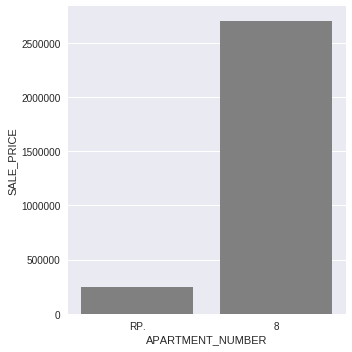

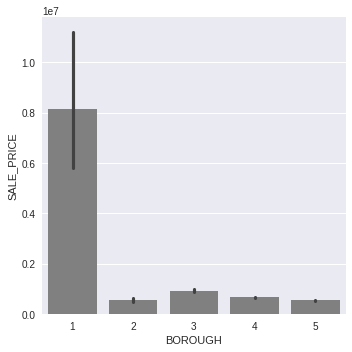

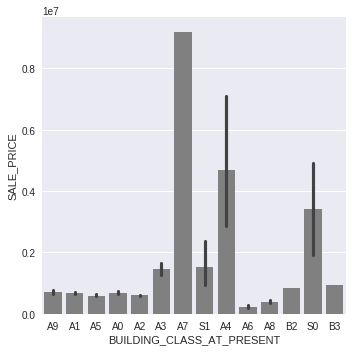

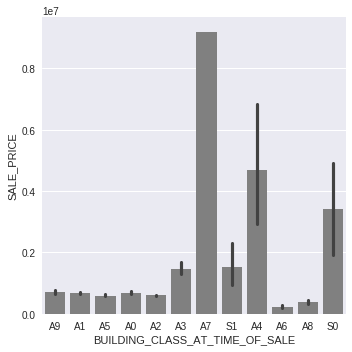

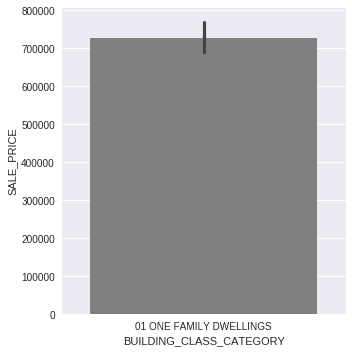

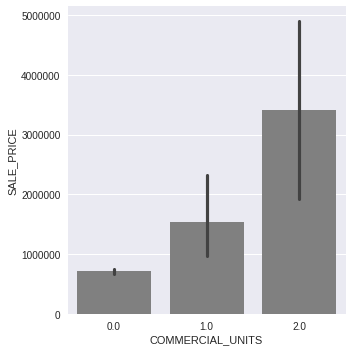

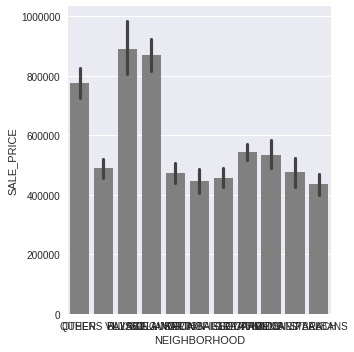

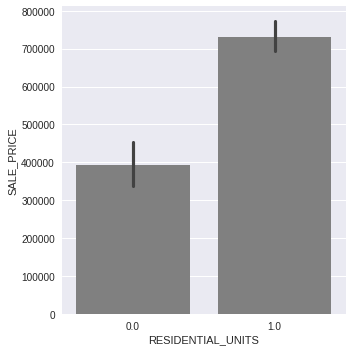

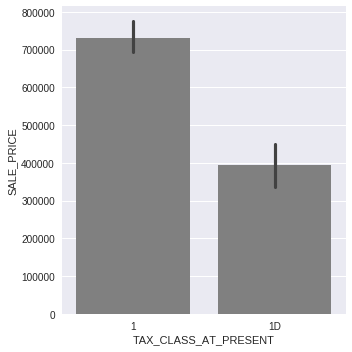

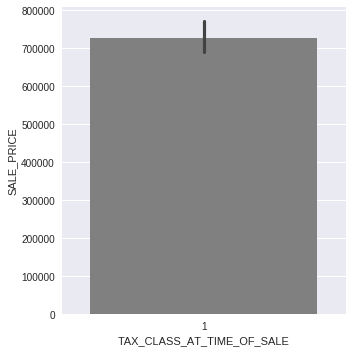

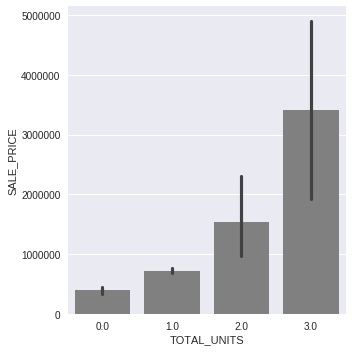

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('seaborn')

for col in sorted(train.columns):
    if (train[col].nunique() <= 20) & (train[col].nunique() > 0):
        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar', color='grey')
        plt.show()

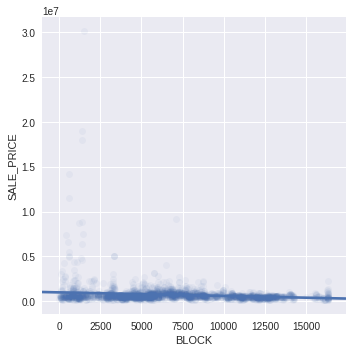

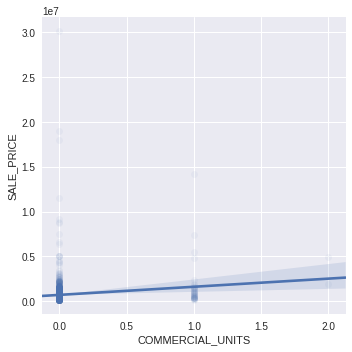

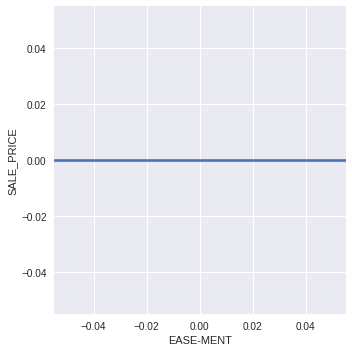

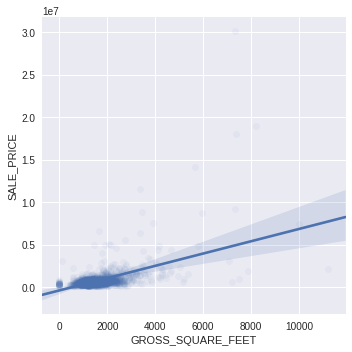

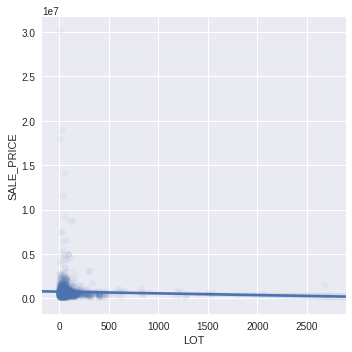

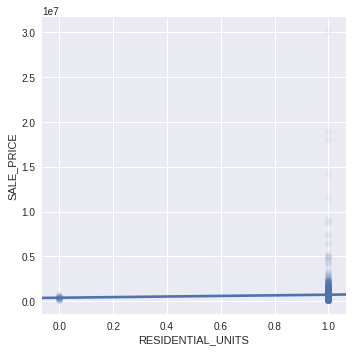

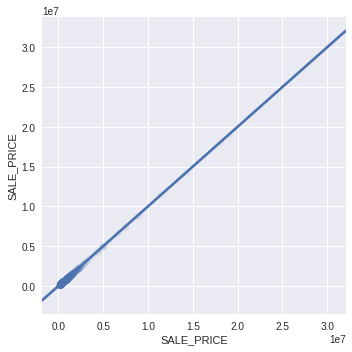

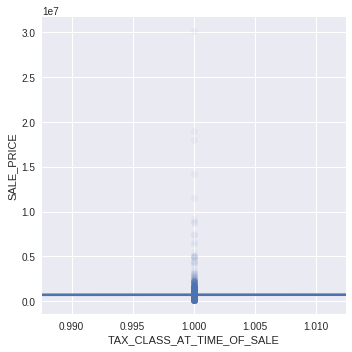

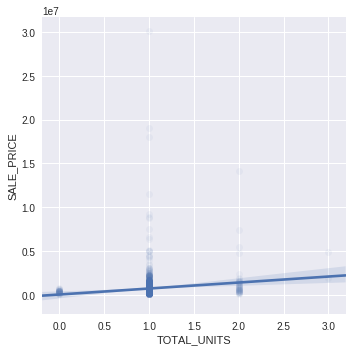

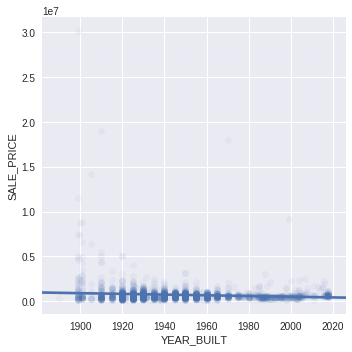

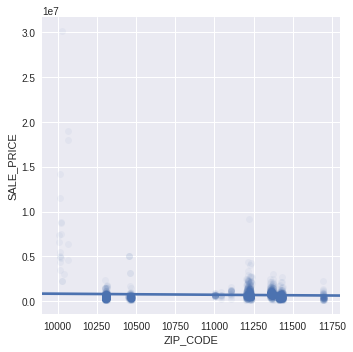

In [14]:
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='SALE_PRICE', data=train, scatter_kws=dict(alpha=0.05))
    plt.show()

In [15]:
# look at nonnumeric features

train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2576,2576,2576,2576,2576,2576,2,2576,2576,2576
unique,5,11,1,2,14,2565,2,921,12,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,750 WEST 232 STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1215,1976,2576,2545,937,2,1,237,937,80
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [18]:
# check cardinality of non numeric features

train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2576,1,01 ONE FAMILY DWELLINGS,2576,NaN,NaN
TAX_CLASS_AT_PRESENT,2576,2,1,2545,NaN,NaN
APARTMENT_NUMBER,2,2,RP.,1,NaN,NaN
BOROUGH,2576,5,4,1215,NaN,NaN
NEIGHBORHOOD,2576,11,OTHER,1976,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2576,12,A1,937,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2576,14,A1,937,NaN,NaN
SALE_DATE,2576,68,2019-01-31 00:00:00,80,2019-01-01 00:00:00,2019-03-30 00:00:00
LAND_SQUARE_FEET,2576,921,"4,000",237,NaN,NaN
ADDRESS,2576,2565,750 WEST 232 STREET,2,NaN,NaN


In [117]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

target = 'SALE_PRICE'
features = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_AT_TIME_OF_SALE']

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $290,855 

2 features
Test MAE: $286,010 

3 features
Test MAE: $282,981 

4 features
Test MAE: $286,338 

5 features
Test MAE: $285,240 

6 features
Test MAE: $276,160 

7 features
Test MAE: $273,607 

8 features
Test MAE: $274,496 

9 features
Test MAE: $273,389 

10 features
Test MAE: $273,536 

11 features
Test MAE: $271,697 

12 features
Test MAE: $272,988 

13 features
Test MAE: $273,366 

14 features
Test MAE: $275,636 

15 features
Test MAE: $273,224 

16 features
Test MAE: $272,379 

17 features
Test MAE: $269,370 

18 features
Test MAE: $267,621 

19 features
Test MAE: $266,899 

20 features
Test MAE: $265,192 

21 features
Test MAE: $265,292 

22 features
Test MAE: $266,191 

23 features
Test MAE: $266,110 

24 features
Test MAE: $259,770 

25 features
Test MAE: $259,932 

26 features
Test MAE: $260,123 

27 features
Test MAE: $259,726 

28 features
Test MAE: $259,708 



In [0]:
train_merged = pd.merge(train, X_train_encoded, left_index=True, right_index=True)
test_merged = pd.merge(test, X_test_encoded, left_index=True, right_index=True)

In [125]:
train_merged.select_dtypes('number').columns

Index(['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE', 'BOROUGH_3', 'BOROUGH_4',
       'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_QUEENS VILLAGE', 'NEIGHBORHOOD_BAYSIDE',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_LAURELTON',
       'NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK',
       'NEIGHBORHOOD_SPRINGFIELD GARDENS', 'NEIGHBORHOOD_GREAT KILLS',
       'NEIGHBORHOOD_SOUTH OZONE PARK', 'NEIGHBORHOOD_MIDLAND BEACH',
       'NEIGHBORHOOD_ST. ALBANS', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A7',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIM

In [126]:
import numpy as np
def lr(train, test, features, target):
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    print(f'Linear Regression with {len(features)} features')
    print('Intercept', model.intercept_)
    coefficients = pd.Series(model.coef_, features)
    print(coefficients.to_string())
    
    print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('Test Root Mean Square Error:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('Train Mean Absolute Error:', mean_absolute_error(y_train, y_pred_train))
    print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred_test))
    print('Train R^2 Score:', r2_score(y_train, y_pred_train))
    print('Test R^2 Score:', r2_score(y_test, y_pred_test))
    
    return

    
target = 'SALE_PRICE'
features = ['BLOCK', 'LOT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BOROUGH_3', 'BOROUGH_4',
       'BOROUGH_2', 'BOROUGH_5', 'BOROUGH_1', 'NEIGHBORHOOD_OTHER',
       'NEIGHBORHOOD_QUEENS VILLAGE', 'NEIGHBORHOOD_BAYSIDE',
       'NEIGHBORHOOD_FLUSHING-NORTH', 'NEIGHBORHOOD_LAURELTON',
       'NEIGHBORHOOD_SO. JAMAICA-BAISLEY PARK',
       'NEIGHBORHOOD_SPRINGFIELD GARDENS', 'NEIGHBORHOOD_GREAT KILLS',
       'NEIGHBORHOOD_SOUTH OZONE PARK', 'NEIGHBORHOOD_MIDLAND BEACH',
       'NEIGHBORHOOD_ST. ALBANS', 'BUILDING_CLASS_AT_TIME_OF_SALE_A9',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A7',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A4',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
       'BUILDING_CLASS_AT_TIME_OF_SALE_S0']
lr(train_merged, test_merged, features, target)

Linear Regression with 37 features
Intercept 7126229.23508932
BLOCK                                   -2.332007e+01
LOT                                     -9.087815e+01
ZIP_CODE                                -3.452905e+02
RESIDENTIAL_UNITS                        2.101865e+05
COMMERCIAL_UNITS                        -5.585059e+05
TOTAL_UNITS                             -3.483194e+05
GROSS_SQUARE_FEET                        4.448038e+02
YEAR_BUILT                              -6.836229e+02
TAX_CLASS_AT_TIME_OF_SALE               -4.656613e-09
BOROUGH_3                               -7.659560e+05
BOROUGH_4                               -7.814708e+05
BOROUGH_2                               -1.374745e+06
BOROUGH_5                               -1.444878e+06
BOROUGH_1                                4.367049e+06
NEIGHBORHOOD_OTHER                      -7.397845e+03
NEIGHBORHOOD_QUEENS VILLAGE             -8.880594e+04
NEIGHBORHOOD_BAYSIDE                     8.403169e+04
NEIGHBORHOOD_FLUSHIN